# Learning Deep Generative Models of Graph
    This notebook is implemantion for Pytorch.
    You can train dataset with running all below cells in order.

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import math

import torch
from torch import tensor
import torch.optim as optim
from torch import autograd
import torch.utils.data as D
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import Bernoulli

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem

import math
from tqdm import tqdm_notebook as tqdm
from itertools import chain

from IPython.display import clear_output
from ipywidgets import interact
from bokeh.models import ColumnDataSource
from bokeh.layouts import column, row
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

import deepchem as dc
from deepchem.molnet import load_tox21

import h5py
import os



output_notebook()

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)

/root/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

In [2]:
class Model(nn.Module):
    def __init__(self, feat_size, N_Max_atom, N_Max_bond, parts, T):
        super(Model, self).__init__()
        self.N_Max_atom = N_Max_atom
        self.N_Max_bond = N_Max_bond
        self.parts = parts
        self.T = T
        self.feat_size = feat_size
        self.E_node = nn.Embedding(1 + len(self.parts[0]), feat_size, padding_idx=0)
        self.E_edge = nn.Embedding(len(self.parts[1]), feat_size)
        
        #f_an
        
        self.f_e_an = nn.ModuleList([nn.Linear(3*feat_size, 3*feat_size*2) for _ in range(self.T)])
        self.f_n_an = nn.ModuleList([nn.GRUCell(3*feat_size*2, feat_size) for _ in range(self.T)])
        
        self.f_m_an = nn.Linear(feat_size, feat_size*2)
        self.g_m_an = nn.Linear(feat_size, 1)
        
        self.f_an = nn.Linear(feat_size*2, 1+len(self.parts[0]))
        
        #hv initialize
        
        self.f_m_init = nn.Linear(feat_size, feat_size*2)
        self.g_m_init = nn.Linear(feat_size, 1)
        
        self.f_init = nn.Linear(feat_size + feat_size*2, feat_size)
        
        #f_ae
        
        self.f_e_ae = nn.ModuleList([nn.Linear(3*feat_size, 3*feat_size*2) for _ in range(self.T)])
        self.f_n_ae = nn.ModuleList([nn.GRUCell(3*feat_size*2, feat_size) for _ in range(self.T)])
        
        self.f_m_ae = nn.Linear(feat_size, feat_size*2)
        self.g_m_ae = nn.Linear(feat_size, 1)
         
        self.f_ae = nn.Linear(feat_size*2, 1)
        
        #f_s
        
        self.f_e_s = nn.ModuleList([nn.Linear(3*feat_size, 3*feat_size*2) for _ in range(self.T)])
        self.f_n_s = nn.ModuleList([nn.GRUCell(3*feat_size*2, feat_size) for _ in range(self.T)])
        
        self.f_s = nn.Linear(feat_size*2, len(self.parts[1]) )
        
        
    def forward(self):
        adj = [[] for _ in range(self.N_Max_atom)]
        node = tensor([])
        edge = []
        y_hat_node = tensor([])
        y_hat_edge = tensor([])
        emb_edge = tensor([])

        h_V = torch.zeros(1, self.feat_size)
        h_G = torch.zeros(1, self.feat_size*2)
        p_addnode = F.softmax(self.f_an(h_G),dim=-1)
        
        if torch.sum(torch.isnan(p_addnode)) >= 1:
                node_type = 0
        else:
            node_type = Categorical(p_addnode).sample()
        
        t = 0
        while int(node_type) != 0 and t < self.N_Max_atom:
            #print(t)
            node = torch.cat((node, node_type.float()), -1)
            y_hat_node = torch.cat((y_hat_node, p_addnode), 0)
            
            emb_node = self.E_node(node_type.view(-1,1)).view(1,-1)
            h_v_new = self.h_v_init(h_V, emb_node, self.f_m_init, self.g_m_init, self.f_init)
            
            if t == 0:
                h_V = h_v_new
            else:
                h_V = torch.cat((h_V, h_v_new), 0)

            h_G = self.prop_and_R(h_V, emb_edge, adj, self.f_e_ae, self.f_n_ae, self.f_m_ae, self.g_m_ae)
            
            p_addedge = F.softmax(self.f_ae(h_G), dim=1)
            if torch.isnan(p_addedge):
                z_t = 0
            else:
                z_t = Bernoulli(p_addedge).sample()
            
            emb_edge_sub = tensor([])
            emb_edge_candi = tensor([650])
            i = 0
            while int(z_t) == 0 and len(emb_edge_sub) <= 8:
                #print(i)
                
                if i == 0:
                    adjust = torch.zeros(1, 8, self.feat_size)
                    emb_edge_candi = torch.cat((emb_edge, adjust), 0)
                    h_U = self.prop(h_V, emb_edge_candi, adj, self.f_e_s, self.f_n_s)
                else:
                    h_U = self.prop(h_V, emb_edge_candi, adj, self.f_e_s, self.f_n_s)
                
                
                p_nodes = self.nodes(h_U, adj, self.f_s)
                
                
                if torch.sum(torch.isnan(p_nodes)) >= 1:
                    adjust = torch.zeros(8 - len(emb_edge_sub), self.feat_size)
                    emb_edge_sub_candi = torch.cat((emb_edge_sub, adjust), 0).view(1, 8, -1)
                    emb_edge_candi = torch.cat((emb_edge, emb_edge_sub_candi), 0)
                    
                else:
                    position = Categorical(p_nodes).sample()
                    
                    node_edgetype = self.node_edgetype(h_V, position)
                    adj[t].append(node_edgetype[0])
                    edge.append([t] + node_edgetype)
                
                    node_position = torch.zeros(1, self.N_Max_atom)
                    node_position[0, node_edgetype[0]] = 1
                    if p_nodes.size(1) < self.N_Max_atom * len(self.parts[1]):
                        adjust = torch.zeros((1, self.N_Max_atom * len(self.parts[1]) - p_nodes.size(1)))
                        p_nodes = torch.cat((p_nodes, adjust), 1)
                        
                    y_hat_edge_sub = torch.cat((node_position, p_nodes), 1)
                    
                    y_hat_edge = torch.cat((y_hat_edge, y_hat_edge_sub), 0)
                
                    emb_edge_sub_sub = self.E_edge(tensor(node_edgetype[1]).long()).view(1, -1)
                    emb_edge_sub = torch.cat((emb_edge_sub, emb_edge_sub_sub), 0)
                
                    if len(emb_edge_sub) < 8:
                        adjust = torch.zeros(8 - len(emb_edge_sub), self.feat_size)
                        emb_edge_sub_candi = torch.cat((emb_edge_sub, adjust), 0).view(1, 8, -1)
            
                    emb_edge_candi = torch.cat((emb_edge, emb_edge_sub_candi), 0)
                
                
                h_G = self.prop_and_R(h_V, emb_edge_candi, adj, self.f_e_ae, self.f_n_ae, self.f_m_ae, self.g_m_ae)
                
                p_addedge = F.softmax(self.f_ae(h_G), dim=-1)
                if torch.isnan(p_addedge):
                    z_t = 1
                else:
                    z_t = Bernoulli(p_addedge).sample()
                
                i += 1
                
            if torch.sum(emb_edge_candi) == 650:
                adjust = torch.zeros(1, 8, self.feat_size)
                emb_edge = torch.cat((emb_edge, adjust), 0)
            else:
                emb_edge = emb_edge_candi
            
            h_G = self.prop_and_R(h_V, emb_edge, adj, self.f_e_ae, self.f_n_ae, self.f_m_ae, self.g_m_ae)
            
            p_addnode = F.softmax(self.f_an(h_G), dim=1)
            if torch.sum(torch.isnan(p_addnode)) >= 1:
                node_type = 0
            else:
                node_type = Categorical(p_addnode).sample()
            
            t += 1
            
        if len(y_hat_node) < self.N_Max_atom:
            adjust =torch.zeros(self.N_Max_atom - len(y_hat_node), 1+len(self.parts[0]))
            y_hat_node = torch.cat((y_hat_node, adjust) ,0)
        
        if len(y_hat_edge) < self.N_Max_bond:
            adjust = torch.zeros(self.N_Max_bond - len(y_hat_edge), self.N_Max_atom + self.N_Max_atom * len(self.parts[1]))
            y_hat_edge = torch.cat((y_hat_edge, adjust) ,0)
        
        return y_hat_node, y_hat_edge, node, edge   
    
    def prop_and_R(self, h_V, emb, adj, f_e, f_n, f_m, g_m):
        for T in range(self.T):
            for t in range(len(h_V)):
                if len(adj[t]) != 0:    
                    adj_t = tensor(adj[t]).long()
                    if t == 0:
                        h_u = torch.index_select(h_V, 0, adj_t)
                        h_v = torch.cat(([h_V[t].view(1, -1) for _ in range(len(h_u))]), 0)
                        x = emb[t, :len(h_u)]
                        m_u_v = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)
                        m_v_u = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)

                        a_v = m_u_v + m_v_u
                    
                        h_V_new = f_n[T](a_v, h_v)
                        
                    else:
                        h_u = torch.index_select(h_V, 0, adj_t)
                        h_v = torch.cat(([h_V[t].view(1, -1) for _ in range(len(h_u))]), 0)
                        x = emb[t, :len(h_u)]
                        m_u_v = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)
                        m_v_u = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)

                        a_v = m_u_v + m_v_u
                    
                        h_V_new_sub = f_n[T](a_v, h_v)
                        h_V_new = torch.cat((h_V_new, h_V_new_sub), 0)

                else:
                    if t == 0:
                        h_V_new = h_V[t].view(1, -1)
                    else:
                        h_V_new_sub = h_V[t].view(1, -1)
                        h_V_new = torch.cat((h_V_new, h_V_new_sub), 0)
        
        h_V_g = f_m(h_V_new)
        g_V = F.logsigmoid(g_m(h_V))
        h_G = torch.sum(torch.mul(g_V, h_V_g), 0, keepdim=True)
        
        return h_G

    def prop(self, h_V, emb, adj, f_e, f_n):
        for T in range(self.T):
            for t in range(len(h_V)):
                if len(adj[t]) != 0:    
                    adj_t = tensor(adj[t]).long()
                    if t == 0:
                        h_u = torch.index_select(h_V, 0, adj_t)
                        h_v = torch.cat(([h_V[t].view(1, -1) for _ in range(len(h_u))]), 0)
                        x = emb[t, :len(h_u)]
                        m_u_v = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)
                        m_v_u = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)

                        a_v = m_u_v + m_v_u
                    
                        h_V_new = f_n[T](a_v, h_v)
                        
                    else:
                        h_u = torch.index_select(h_V, 0, adj_t)
                        h_v = torch.cat(([h_V[t].view(1, -1) for _ in range(len(h_u))]), 0)
                        x = emb[t, :len(h_u)]
                        m_u_v = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)
                        m_v_u = torch.sum(f_e[T](torch.cat((h_u, h_v, x), 1)), 0, keepdim=True)

                        a_v = m_u_v + m_v_u
                    
                        h_V_new_sub = f_n[T](a_v, h_v)
                        h_V_new = torch.cat((h_V_new, h_V_new_sub), 0)

                else:
                    if t == 0:
                        h_V_new = h_V[t].view(1, -1)
                    else:
                        h_V_new_sub = h_V[t].view(1, -1)
                        h_V_new = torch.cat((h_V_new, h_V_new_sub), 0)

        return h_V_new
        
    def nodes(self, h_U, adj, f_s):
        h_V = torch.cat(([h_U[-1].view(1, -1) for _ in range(len(h_U))]), 0)
        s_u_j = f_s(torch.cat((h_U, h_V), 1)).view(1, -1)
        p_nodes = F.softmax(s_u_j, dim=1)
        
        return p_nodes
    
    def node_edgetype(self, h_V, position):
        empty = torch.zeros(1, len(h_V) * len(self.parts[1]))
        empty[0, position] = 1
        node = int(empty.reshape(len(h_V), len(self.parts[1])).nonzero()[0][0])
        bondtype = int(empty.reshape(len(h_V), len(self.parts[1])).nonzero()[0][1])

        return [node, bondtype]
        
    def h_v_init(self, h_V, e, f_m, g_m, f_init):
        h_v_g_init = f_m(h_V)
        g_v_init = F.logsigmoid(g_m(h_V))
        h_G_init = torch.sum(torch.mul(g_v_init, h_v_g_init), 0, keepdim=True)
        
        h_v = f_init(torch.cat((e, h_G_init), 1))
        
        return h_v

In [3]:
class Featurizer(object):
    def __init__(self, N_Max_atom, N_Max_bond, parts):
        super(Featurizer, self).__init__()
        self.N_Max_atom = N_Max_atom
        self.N_Max_bond = N_Max_bond
        self.parts = parts
    
    def __call__(self, mols, filepass):
        print('mol count')
        self.size = mol_num(mols)
        
        self.f =  h5py.File(filepass, "w")
        
        self.f.create_dataset('atom',shape=(self.size, self.N_Max_atom, 1+len(self.parts[0])))
        self.f.create_dataset('bond',shape=(self.size, self.N_Max_bond, self.N_Max_atom+self.N_Max_atom*len(self.parts[1])))
        
        print('Featurizing atom_type')
        self.atom_type(mols)
        print('Featurizing bond_type')
        self.bond_type(mols)
        
        self.f.flush()
        self.f.close()
        
        print('Done')
        
    def atom_type(self, mols):
        ids = self.f['atom']
        parts = self.parts[0]
        c = -1
        for mol in tqdm(mols):
            if mol is not None:
                mol = Chem.AddHs(mol)
                if mol.GetNumAtoms() <= self.N_Max_atom:
                    c += 1
                    for index_atom , atom in enumerate(mol.GetAtoms()):
                        
                        ids[c, index_atom, parts[atom.GetSymbol()]] = 1
                else:
                    pass
                
    def bond_type(self, mols):
        ids = self.f['bond']
        parts = self.parts[1]
        c = -1
        for mol in tqdm(mols):
            if mol is not None:
                mol = Chem.AddHs(mol)
                if mol.GetNumAtoms() <= self.N_Max_atom:
                    c += 1
                    for index_bond, bond in enumerate(mol.GetBonds()):
                        begin = np.zeros((1,self.N_Max_atom))
                        begin[0, bond.GetBeginAtomIdx()] = 1
                        end = np.zeros((self.N_Max_atom, len(self.parts[1])))
                        end[bond.GetEndAtomIdx(), parts[str(bond.GetBondType())]] = 1
                        sub = np.concatenate((begin,end.reshape(1,-1)), -1)
                        ids[c,index_bond,:] = sub

In [4]:
from io import StringIO
import sys
Chem.WrapLogs()
def write_mol(node_batch, edge_batch, gen_size):
    mols_gen = []
    smiles_gen = []
    failures = []
    count = 0
    
    sio = sys.stderr = StringIO()
    for c in range(gen_size):
        
        m = Chem.MolFromSmiles('') 
        mw = Chem.RWMol(m)
        
        for n in range(len(node_batch[c])):
            try:
                mw.AddAtom(Chem.Atom(int(node_batch[c][n])))
            except:
                failures.append([c, sio.getvalue()])
                sio = sys.stderr = StringIO()
                break

        for e in range(len(edge_batch[c])):
            try:
                mw.AddBond(edge_batch[c][e][0], edge_batch[c][e][1], num_to_bond[edge_batch[c][e][2]])

            except RuntimeError:
                failures.append([c, sio.getvalue()])
                sio = sys.stderr = StringIO()
                break
                
        try:
            Chem.SanitizeMol(mw)
            smiles =Chem.MolToSmiles(mw)
            smiles_gen.append(smiles)
            mols_gen.append(mw)
            count += 1
        except ValueError:
            pass
        
    valid_rate = count / gen_size
    
    return mols_gen, smiles_gen, valid_rate, failures

In [5]:
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def moltosvg(mol, molSize=(400,400), index=False, kekulize=True):
    
    mc = Chem.Mol(mol.ToBinary())
    
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
            
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
        
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    opts = drawer.drawOptions()
    if index:
        for i in range(mc.GetNumAtoms()):
            opts.atomLabels[i] = str(i)

    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    
    return svg.replace('svg:','')

In [6]:
def calc_lr(epoch_num):
    return 0.000000001 * 1.3 ** epoch_num
def mol_num(mols):
    num = sum([1 for mol in tqdm(mols) if mol is not None and int(Chem.AddHs(mol).GetNumAtoms()) <= N_Max_atom ])
    return num

In [7]:
atom_to_num = {}
num_to_atom ={}
for i in range(121):
    if i != 0:
        sub = {Chem.Atom(i).GetSymbol(): i}
        sub2 = {i: Chem.Atom(i).GetSymbol()}
        atom_to_num.update(sub)
        num_to_atom.update(sub2)
bond_to_num = {'AROMATIC': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
num_to_bond = {0: Chem.BondType.AROMATIC, 1: Chem.BondType.SINGLE, 2: Chem.BondType.DOUBLE, 3: Chem.BondType.TRIPLE}
parts = (atom_to_num, bond_to_num)

# Change settings for training set.

In [8]:
zinc_mols = Chem.SmilesMolSupplier('250k_rndm_zinc_drugs_clean.smi',delimiter='\t',titleLine=False)
N_Max_atom = 20 # you can change this number. you can collect mol whose number of node is less than set number. 
                #If you want to use all training data, set 83.
N_Max_bond = 83 # you can't change this number.

#N_Max_bond = max([Chem.AddHs(mol).GetNumBonds() for mol in tqdm(zinc_mols) if mol is not None]) # result in 87
#N_Max_atom = max([Chem.AddHs(mol).GetNumAtoms() for mol in tqdm(zinc_mols) if mol is not None])# result in 83

# Create training data set.

In [9]:
featurizer = Featurizer(N_Max_atom, N_Max_bond, parts)
if not os.path.exists('./zinc.hdf5'):
    print('zinc set')
    featurizer(zinc_mols,'./zinc.hdf5')

# Change settings for Model.

In [10]:
#Settings

batch_size = 8 # you can chenge batch size.
gen_size = 100 # you can change generation times.

#Model - you can change feat_size for node feature and T for propagation times.

classifier = Model(feat_size=128, N_Max_atom=N_Max_atom, N_Max_bond=N_Max_bond, parts=parts, T=2)
torch.save(classifier.state_dict(), './init.pth') 
finder = Model(feat_size=128, N_Max_atom=N_Max_atom, N_Max_bond=N_Max_bond, parts=parts, T=2)
finder.load_state_dict(torch.load('./init.pth'))

#Loss function
criterion_node = nn.BCELoss()
criterion_edge = nn.BCEWithLogitsLoss()

# Run the below cell for training.

In [11]:
#Log

train_logs = []

#Plotting

source_train = ColumnDataSource(data=dict(epoch=[], loss=[], rates=[]))
settings = dict(plot_width=480, plot_height=430, min_border=0)
p = figure(title="Loss", x_axis_label="epoch", y_axis_label="Loss", **settings)
p.line(x='epoch', y='loss', source=source_train)
p2 = figure(title="Generation Valid Rate", x_axis_label="epoch", y_axis_label="Valid rate", **settings)
p2.line(x='epoch', y='rates', source=source_train, color="orange")

t = show(column(p, p2), notebook_handle=True)

#Config

train = h5py.File('./zinc.hdf5', 'r')
classifier.train()
train_x = train['atom']
batch_num = len(train_x) // batch_size

optimizer = optim.Adam(classifier.parameters(), lr=0.0001)  # you can change learning rate.

for epoch in tqdm(range(0,1000)): # you can change a number of epoch.
    
    #Training
    
    for batch in tqdm(range(0,batch_num)):
        
        start = batch*batch_size
        end = batch*batch_size + batch_size
        
        target_node = torch.from_numpy(train['atom'][start:end]).view(-1, N_Max_atom, 1+len(parts[0])).float()
        target_edge = torch.from_numpy(train['bond'][start:end]).view(-1, N_Max_bond, N_Max_atom+N_Max_atom*len(parts[1])).float()
        
        if use_cuda:
            target_node = target_node.cuda()
            target_edge = target_edge.cuda()
            
        y_hat_node_batch = tensor([])
        y_hat_edge_batch = tensor([])
        node_batch = []
        edge_batch = []
        for _ in range(batch_size):
            y_hat_node, y_hat_edge, node, edge = classifier()
            y_hat_node_batch = torch.cat((y_hat_node_batch, y_hat_node.view(1, N_Max_atom, -1)), 0)
            y_hat_edge_batch = torch.cat((y_hat_edge_batch, y_hat_edge.view(1, N_Max_bond, -1)), 0)
            node_batch.append(node.tolist())
            edge_batch.append(edge)
        
        loss_node = criterion_node(y_hat_node_batch, target_node)
        loss_edge = criterion_edge(y_hat_edge_batch, target_edge)
        loss = loss_node + loss_edge
        
        loss.backward()
        optimizer.step()
        classifier.zero_grad()
        
    
    #Generation

    y_hat_node_batch = tensor([])
    y_hat_edge_batch = tensor([])
    node_batch = []
    edge_batch = []
    for _ in range(gen_size):
        y_hat_node, y_hat_edge, node, edge = classifier()
        y_hat_node_batch = torch.cat((y_hat_node_batch, y_hat_node.view(1, N_Max_atom, -1)), 0)
        y_hat_edge_batch = torch.cat((y_hat_edge_batch, y_hat_edge.view(1, N_Max_bond, -1)), 0)
        node_batch.append(node.tolist())
        edge_batch.append(edge)
    
    mols, smiles, valid_rate, failures = write_mol(node_batch, edge_batch, gen_size)
    
    #Write generated mols per epoch
    
    ''' To Do
    writer = Chem.SDWriter(f'./mols/epoch{epoch}.sdf')
    for mol in mols:
        writer.write(mol)
    writer.close()
    '''
    
    #Plot result
    
    if use_cuda:
        loss = loss.cpu()
        
    new_data_train = {'epoch' : [epoch], 'loss' : [loss.detach().numpy()], 'rates' : [valid_rate]}
    new_data_train_df = {'epoch' : epoch, 'loss' : loss.detach().numpy(), 'rates' : valid_rate}
    
    source_train.stream(new_data_train)
    
    train_logs.append(new_data_train_df)
    df_train = pd.DataFrame(train_logs)
    df_train.to_csv("./train_logs.csv", index=False)
    
    #Show plots
    
    push_notebook(handle=t)
    
    #Save model
    
    torch.save(classifier.state_dict(), f'./models/epoch{0}.pth')
        
clear_output()

train_logs = pd.read_csv('./train_logs.csv')

source_train = ColumnDataSource(train_logs)

t = show(column(p, p2), notebook_handle=True)

train.flush()
train.close()

print("Done")

Done


# Generation Graph
    You can change gen_size for the number of generating graph.

In [13]:
gen_size = 100 

y_hat_node_batch = tensor([])
y_hat_edge_batch = tensor([])
node_batch = []
edge_batch = []
for _ in range(gen_size):
    y_hat_node, y_hat_edge, node, edge = classifier()
    y_hat_node_batch = torch.cat((y_hat_node_batch, y_hat_node.view(1, N_Max_atom, -1)), 0)
    y_hat_edge_batch = torch.cat((y_hat_edge_batch, y_hat_edge.view(1, N_Max_bond, -1)), 0)
    node_batch.append(node.tolist())
    edge_batch.append(edge)
    
mols_gen, smiles_gen, valid_rate_gen, failures = write_mol(node_batch, edge_batch, gen_size)

# Show Generated Graph
    You can change index number (0 <= index <= gen_size)

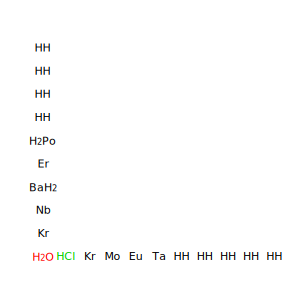

In [14]:
index = 50
SVG(moltosvg(mols_gen[index], molSize=(300,300), index=False))

# Show Plot

In [15]:
train_logs = pd.read_csv('./train_logs.csv')

source_train = ColumnDataSource(train_logs)
settings = dict(plot_width=480, plot_height=430, min_border=0)
p = figure(title="Binary Cross Entropy Loss with Sigmoid Layer", x_axis_label="epoch",y_axis_label="Loss", **settings)
p.line(x='epoch', y='loss', source=source_train, legend="Train")

draw = show(p, notebook_handle=True)

# Find Optim Learning rate. (Option)
    Choice the learning rate before increasing loss.

In [30]:
##Optimal learning rates

#Log

find_logs = []

#Plotting

source_find = ColumnDataSource(data=dict(epoch=[], loss=[], lr=[]))
settings = dict(plot_width=480, plot_height=430, min_border=0)
pf = figure(title="Optimal learning rates", x_axis_label="epoch",y_axis_label="Loss", **settings)
pf.line(x='epoch', y='loss', source=source_find)

pf2 = figure(title="Corresponding Learning rate", x_axis_label="epoch", y_axis_label="Learning rate", **settings)
pf2.line(x='epoch', y='lr', source=source_find, color="orange")

tf = show(column(pf,pf2), notebook_handle=True)

#Config
train = h5py.File('./zinc.hdf5', 'r')
finder.train()
finder_x = train['atom'][:batch_size]
batch_num = len(finder_x) // batch_size

optimizer_find = optim.Adam(finder.parameters(), lr=calc_lr(50))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_find, 1.3, last_epoch=-1)

for epoch in tqdm(range(50,80)):
    
    #Training
    
    for batch in tqdm(range(0,batch_num), disable=True):
        
        start = batch*batch_size
        end = batch*batch_size + batch_size
        
        target_node = torch.from_numpy(train['atom'][start:end]).view(-1, N_Max_atom, 1+len(parts[0])).float()
        target_edge = torch.from_numpy(train['bond'][start:end]).view(-1, N_Max_bond, N_Max_atom+N_Max_atom*len(parts[1])).float()
        
        if use_cuda:
            target_node = target_node.cuda()
            target_edge = target_edge.cuda()
            
        y_hat_node_batch = tensor([])
        y_hat_edge_batch = tensor([])
        node_batch = []
        edge_batch = []
        for _ in range(batch_size):
            y_hat_node, y_hat_edge, node, edge = finder()
            y_hat_node_batch = torch.cat((y_hat_node_batch, y_hat_node.view(1, N_Max_atom, -1)), 0)
            y_hat_edge_batch = torch.cat((y_hat_edge_batch, y_hat_edge.view(1, N_Max_bond, -1)), 0)
            node_batch.append(node.tolist())
            edge_batch.append(edge)
        
        loss_node = criterion_node(y_hat_node_batch, target_node)
        loss_edge = criterion_edge(y_hat_edge_batch, target_edge)
        loss = loss_node + loss_edge
        
        loss.backward()
        optimizer_find.step()
        finder.zero_grad()

    #Logiging 
    if use_cuda:
        loss = loss.cpu()
    new_data_find = {'epoch' : [epoch], 'loss' : [loss.detach().numpy()], 'lr' : [calc_lr(epoch)]}
    new_data_find_df = {'epoch' : epoch, 'loss' : loss.detach().numpy(), 'lr' : calc_lr(epoch)}
    source_find.stream(new_data_find)
    
    find_logs.append(new_data_find_df)
    df_find = pd.DataFrame(find_logs)
    df_find.to_csv("./find_logs.csv", index=False)
    
    scheduler.step()
    
    #Show plots
    
    push_notebook(handle=tf)

clear_output()

find_logs = pd.read_csv('./find_logs.csv')
source_find = ColumnDataSource(find_logs)

tf = show(column(pf,pf2))

print('Done')

Done
